# Class Activation Map 만들기
- CAM을 만들고 평가해 보자
- 미리 학습된 모델
[여기](https://github.com/phthys/Aiffel_GoingDeeper/blob/main/%5BG_06%5Dcam_model_make.ipynb)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete3073RM/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete3073RM/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [3]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

108


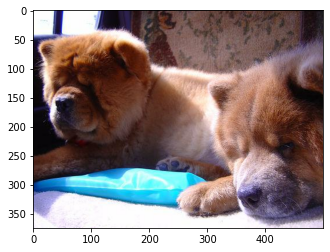

In [5]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [7]:
cam_model_path = '/content/drive/MyDrive/data/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

- 미리 학습된 모델 불러오기

## CAM 구현하기

In [10]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

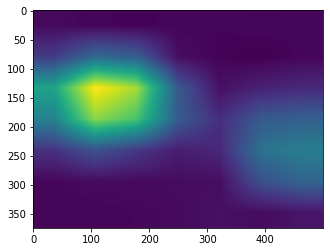

In [11]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [12]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

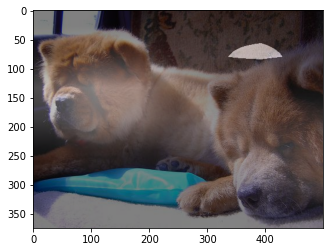

In [18]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM 구현하기

In [20]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

- 여러 레이어의 CAM 이미지를 확인

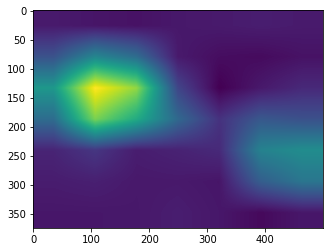

In [26]:
grad_cam_image53 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image53)

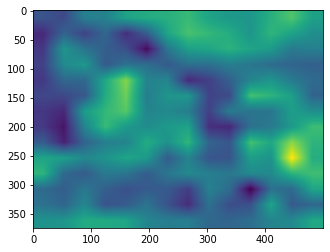

In [27]:
grad_cam_image43 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image43)

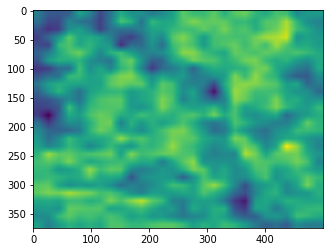

In [28]:
grad_cam_image33 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image33)

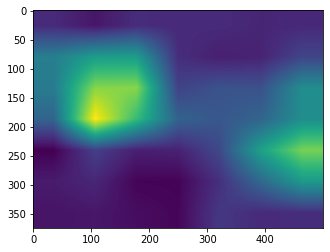

In [29]:
grad_cam_image52 = generate_grad_cam(cam_model, 'conv5_block2_out', item)
plt.imshow(grad_cam_image52)

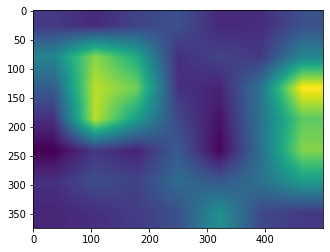

In [30]:
grad_cam_image51 = generate_grad_cam(cam_model, 'conv5_block1_out', item)
plt.imshow(grad_cam_image51)

- 이미지 시각화 해보기

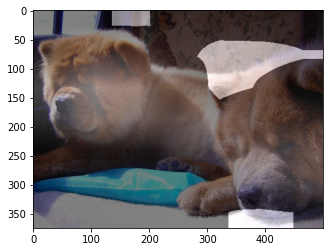

In [35]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image53_3channel = np.stack([grad_cam_image53*255]*3, axis=-1).astype(np.uint8)

blended_image53 = visualize_cam_on_image(grad_cam_image53_3channel, origin_image)
plt.imshow(blended_image53)

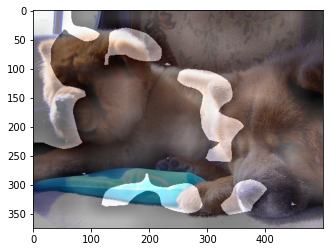

In [32]:
grad_cam_image43_3channel = np.stack([grad_cam_image43*255]*3, axis=-1).astype(np.uint8)

blended_image43 = visualize_cam_on_image(grad_cam_image43_3channel, origin_image)
plt.imshow(blended_image43)

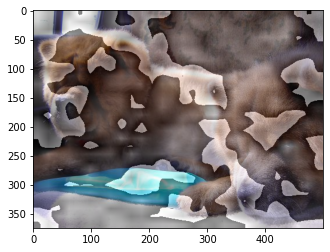

In [36]:
grad_cam_image33_3channel = np.stack([grad_cam_image33*255]*3, axis=-1).astype(np.uint8)

blended_image33 = visualize_cam_on_image(grad_cam_image33_3channel, origin_image)
plt.imshow(blended_image33)

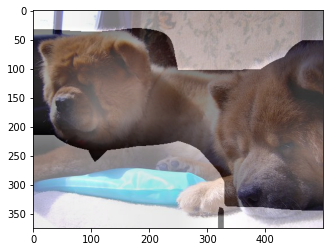

In [37]:
grad_cam_image52_3channel = np.stack([grad_cam_image52*255]*3, axis=-1).astype(np.uint8)

blended_image52 = visualize_cam_on_image(grad_cam_image52_3channel, origin_image)
plt.imshow(blended_image52)

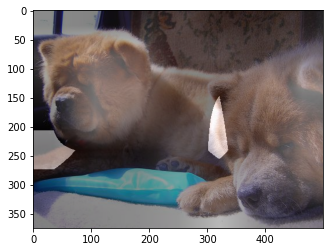

In [38]:
grad_cam_image51_3channel = np.stack([grad_cam_image51*255]*3, axis=-1).astype(np.uint8)

blended_image51 = visualize_cam_on_image(grad_cam_image51_3channel, origin_image)
plt.imshow(blended_image51)

## 바운딩 박스

40


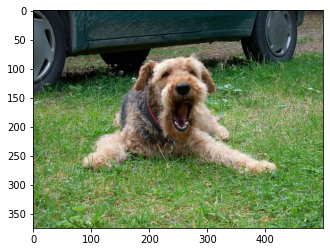

In [40]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

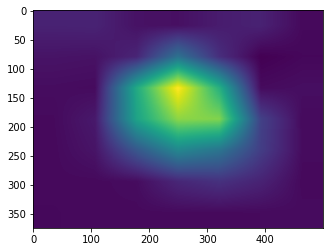

In [41]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [42]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [43]:
rect = get_bbox(cam_image)
rect

array([[132, 358],
       [ 79,  39],
       [409, -15],
       [462, 302]])

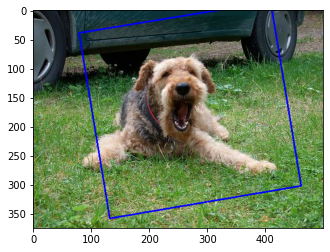

In [44]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## IOU 구하기

In [45]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

슝=3


In [46]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.04, 0.158, 0.9546666666666667, 0.924]

In [47]:
item['objects']['bbox']

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)

In [48]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

슝=3


In [51]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4994784816706856

## CAM, Grad-CAM 비교해보기

67


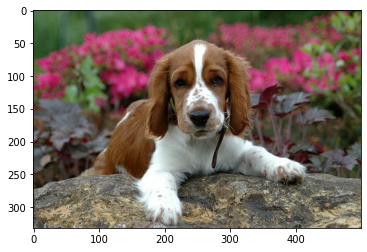

In [52]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

### CAM

In [53]:
cam_image = generate_cam(cam_model, item)

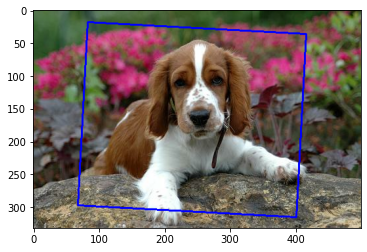

In [54]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [57]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.8517665220444528

### Grad-CAM

In [58]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

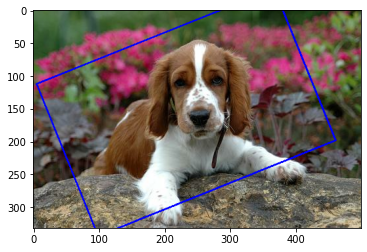

In [59]:
image = copy.deepcopy(item['image'])
rect = get_bbox(grad_cam_image)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [60]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5597049523223144

- 다른 레이어도 해보기

In [65]:
grad_cam_image52 = generate_grad_cam(cam_model, 'conv5_block2_out', item)

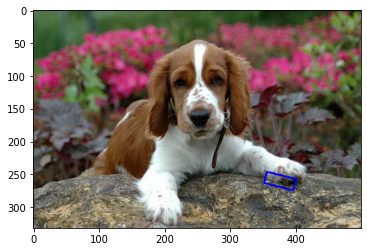

In [66]:
image = copy.deepcopy(item['image'])
rect = get_bbox(grad_cam_image52)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [67]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.014258990146417863

In [71]:
grad_cam_image51 = generate_grad_cam(cam_model, 'conv5_block1_out', item)

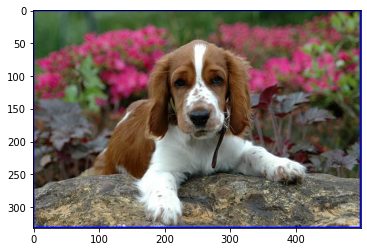

In [72]:
image = copy.deepcopy(item['image'])
rect = get_bbox(grad_cam_image51)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [73]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5825548242323544

In [68]:
grad_cam_image43 = generate_grad_cam(cam_model, 'conv4_block3_out', item)

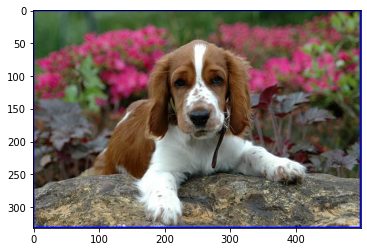

In [69]:
image = copy.deepcopy(item['image'])
rect = get_bbox(grad_cam_image43)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [70]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5825548242323544

- CAM이 가장 나은 성능을 보였다.
- Grad-CAM의 경우 'conv5_block3_out' 레이어 말고는 바운딩박스 상태가 좋지 않아보인다.
- 다른 이미지로 다시 시도해봐야겠다.

80


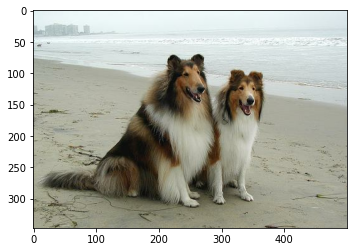

In [77]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

### CAM

In [78]:
cam_image = generate_cam(cam_model, item)

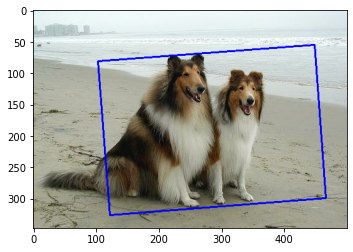

In [79]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [80]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.3773659591515017

### Grad-CAM

In [84]:
grad_cam_image53 = generate_grad_cam(cam_model, 'conv5_block3_out', item)

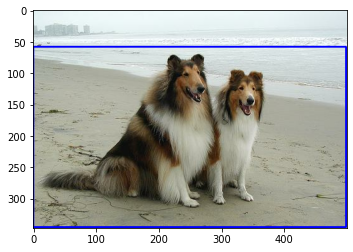

In [85]:
image = copy.deepcopy(item['image'])
rect = get_bbox(grad_cam_image53)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [86]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4802065597585651

In [87]:
grad_cam_image52 = generate_grad_cam(cam_model, 'conv5_block2_out', item)

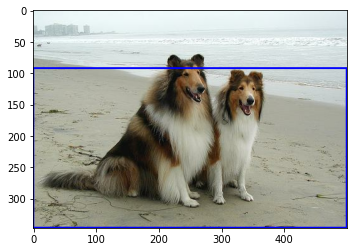

In [88]:
image = copy.deepcopy(item['image'])
rect = get_bbox(grad_cam_image52)

image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [89]:
pred_bbox = rect_to_minmax(rect, item['image'])
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4641567208863383

- 해당 이미지는 수치상으론 Grad-CAM이 더 높은거 같지만, 바운딩박스 이미지만 봤을땐 역시 CAM이 더 나은거같다.